In [2]:
#!pip install stable-baselines3[extra]

# -- Prerequisites install 
!pip3 install stable_baselines3 --user
!pip3 install stable_baselines3 --user
!pip3 install ipykernel --user
!pip3 install tensorboard --user

^C


In [28]:

import stable_baselines3

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env


#from stable_baselines3 import DQN,PPO,A2C
from stable_baselines3 import PPO
import os


from hyperopt import hp,fmin,tpe
import torch as th
import math



def set_up_model(params, env):
    log_path = os.path.join('Training', 'Logs')
    hidden_layers_policy_network = params['hidden_layers_policy_network']
    size_hidden_layers_policy_network = params['size_hidden_layers_policy_network']
    hidden_layers_value_network = params['hidden_layers_value_network']
    size_hidden_layers_value_network = params['size_hidden_layers_value_network']

    net_arch = [dict(pi=([size_hidden_layers_policy_network] * hidden_layers_policy_network),vf=([size_hidden_layers_value_network] * hidden_layers_value_network))]

    activation_fn = {"tanh": th.nn.Tanh, "relu": th.nn.ReLU, "elu": th.nn.ELU, "leaky_relu": th.nn.LeakyReLU}[params['activation_fn']]

    policy_kwargs = dict(net_arch=net_arch,
                    ortho_init=params['ortho_init'],
                    activation_fn=activation_fn)

    batch_size = math.gcd(params['batch_size'],params['n_steps'])

    model = PPO("MlpPolicy",
                env, 
                learning_rate=params['learning_rate'], 
                n_steps=params['n_steps'], 
                batch_size=batch_size, 
                n_epochs=params['n_epochs'], 
                gamma=params['gamma'], 
                gae_lambda=params['gae_lambda'], 
                clip_range=params['clip_range'], 
                ent_coef=params['ent_coef'], 
                vf_coef=params['vf_coef'], 
                max_grad_norm=params['max_grad_norm'],
                policy_kwargs=policy_kwargs,
                verbose=0, 
                tensorboard_log=log_path,
                device='cuda')
    return model




space = {
        'learning_rate': 5e-6,
        'n_steps': 128,
        'batch_size': 128,
        'n_epochs': 10,
        'gamma': 0.99,
        'gae_lambda': 0.9,
        'clip_range': 0.2,
        'ent_coef': 0,
        'vf_coef': 0.5,
        'max_grad_norm': 0.5,
        'lr_schedule': 'linear',
        'hidden_layers_policy_network': 2,
        'size_hidden_layers_policy_network': 128,
        'hidden_layers_value_network': 2,
        'size_hidden_layers_value_network': 128,
        'ortho_init': False,
        'activation_fn': "relu"
    }


log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = BatteryEnv()
env = Monitor(env, log_dir)


check_env(env, warn=True)

print(hp.choice('hidden_layers_policy_network', [1,2,3,4]))

model = set_up_model(space,env)

model.learn(total_timesteps=1000)






0 switch
1   hyperopt_param
2     Literal{hidden_layers_policy_network}
3     randint
4       Literal{4}
5   Literal{1}
6   Literal{2}
7   Literal{3}
8   Literal{4}


C:\Users\A493191\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\policies.py:484: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


# STABLEBASELINES TESTBED

In [192]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union

#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, nr_batteries, render_mode: Optional[str] = None):
      super().__init__()
      #self.zk = 9.8  # = SOC
      #self.hk = 1.0  # = hysteresis state
      #self.t = 1.0   # = temperature
      #self.vk = 1.0
      #self.rck = 1.0 # = Current through paralel resistor

      #     action_high = np.array(
      #       [
      #       #   10,         #min= 0, max= 10       Voltage (v) - vk
      #          80,        #min= 0, max= 100      SOC - zk
      #          80,        #min= 0, max= 100      SOC - zk
      #       #   150,        #min= -30, max= 150    Temperature  - t
      #       #   1,          #min= -1, max= 1       Hysteresis state - hk
      #       #   100,        #min= -100, max= 100   Current through paralel resistor - rck
      #       #   33459,      # time 
      #       #   np.finfo(np.float32).max,   #min= Inf, max= Inf
      #    ],
      #    dtype=np.float64,
      # )
      
      #...

      self.env_id = "Battery v0.3"
      self.num_envs = 1
      
      # SOHt​=f(SOCt​,CRt​) - soh as function of charge rate and soc
      # SOHt​=SOHt−1​−k×CRt​
      self.degradation_coeficient = 0.2

      self.soc_threshold_upper = 85
      self.soc_threshold_lower = 15

      self.episode_time = 0

      self.nr_batteries = nr_batteries



      high = np.array(
            [
               100,        #min= 0, max= 100      SOC - zk
               100,        #min= 0, max= 100      SOC - zk
         ],
         dtype=np.float32,
      )

      low = np.array(
            [
               0,
               0,
         ],
         dtype=np.float32,
      )


      self.action_space = gym.spaces.Box(-1, 1, (self.nr_batteries,), dtype=np.float32) # cell1,cell2,cell3... and voltage
      self.observation_space = gym.spaces.Box(0, 100, (self.nr_batteries,), dtype=np.float32)

      self.state = None
      self.steps_beyond_terminated = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      battery_current_values = get_converted_action(action)

      #vk, zk, t, hk, rck, time = self.state


      # discharge until 15, and 85 limilits
      #print(action)


      self.episode_time += 1
      passed_threshold = False
      exiting_observation_space = False

      self.state = np.subtract(self.state, battery_current_values)         

      for soc in self.state:

         if (soc < self.soc_threshold_lower or soc > self.soc_threshold_upper):
            passed_threshold = True
         if (soc < 0 or soc > 100):
            # EXITED OBSERVATION SPACE. Terminate immediatley.
            soc = 0.0
            exiting_observation_space = True
            print("//////// EXITED OBSERVATION SPACE BOUNDS ////////  "  + str(soc))
            #return np.array(self.state , dtype=np.float32), -10000000000000, True, False, {}


      if exiting_observation_space:
         # Terminate. Apply penalty.
         return np.array(self.state , dtype=np.float32), -100000, True, False, {}



      # right now the reward in only based on if the variables fall out of bounds 
      # passed_thr = bool(
      #    soc0 < self.soc_threshold_lower
      #    or soc0 > self.soc_threshold_upper
      #    or soc1 < self.soc_threshold_lower
      #    or soc1 > self.soc_threshold_upper
      #    # time doesnt really make sense here for now
      #    #or time < 0
      #    #or time > 33458
      # )


      terminated = False

      reward = 0
      if not passed_threshold and self.episode_time == 128:
         # Timeout
         self.episode_time = 0
         # reward = 0
         reward = compute_ballancing_reward(self.state, False)
         terminated = True
      elif not passed_threshold:
         # Apply cost(reward)
         # if (math.isclose(soc0, soc1, abs_tol=1)):
         #    reward = 0
         # else:
         reward = compute_ballancing_reward(self.state, False)

      
      elif passed_threshold:
         # Batteries drained! Terminated.
         self.steps_beyond_terminated = 0
         
         #terminated = True
         #self.episode_time = 0
         reward = -10000

         #if self.episode_time == 128:
         terminated = True

      # Sanity check. Do not continue steps after termination. Call reset first.
      # if self.steps_beyond_terminated > 0:
      #    print(
      #       "You are calling 'step()' even though this "
      #       "environment has already returned terminated = True. You "
      #       "should always call 'reset()' once you receive 'terminated = "
      #       "True' -- any further steps are undefined behavior."
      #    )
      #    self.steps_beyond_terminated += 1
      #    reward = 0.0


      if self.render_mode == "human":
         self.render()
      
      return np.array(self.state, dtype=np.float32), float(reward), terminated, False, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        

         super().reset(seed=seed)
         # Note that if you use custom reset bounds, it may lead to out-of-bound
         # state/observations.
         #high = utils.maybe_parse_reset_bounds(
         #    options, -0.05, 0.05  # default low
         #)  # default high


         self.episode_time = 0

         #definition of an episode: 1 whole run of the matlab script
         #                               OR
         #                          1 segment of it?

         self.state = self.np_random.uniform(low=15, high=85, size=(self.nr_batteries,))

         self.steps_beyond_terminated = None

         if self.render_mode == "human":
               self.render()
         return np.array(self.state, dtype=np.float32), {}



def compute_ballancing_reward(socs, should_print):

   
   #cost as distance between 2 numbers
   #reward = -pow(soc0 - soc1, 2)
   
   #cost as standard deviation
   reward = -np.std(socs, dtype=np.float32)

   # if(should_print):
   #    print( "SOC Mean: " + str(mean) +  "    ---- SOC1 Difference    "  + str(difference1)  +  "    ----   SOC2 Difference    "  + str(difference2))

   return reward


def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = (current + 1.0) * 5.0  #from [-1, 1] to [0, 10]
      current_values.append(shifted_value)

   return current_values




In [193]:
import torch

def plot_step(episode_number, state, action, reward, show_result=False):
    
    fig = plt.figure(1)

    actions_t = torch.tensor(action, dtype=torch.float)
    rewards_t = torch.tensor(reward, dtype=torch.float)

    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('SOC & Actions')



    # Plot SOCs
    soc0 = []
    soc1 = []
    for st in state:
        # states_t = torch.tensor(st, dtype=torch.float)
        # plt.plot(states_t.cpu().squeeze().numpy(), label='State ' + str(st))

        soc0.append(st[0][0].item())
        soc1.append(st[0][1].item())
    
    plt.plot(soc0, label='soc0')
    plt.plot(soc1, label='soc1')



    # Plot actions as indvidual points
    action_array = np.multiply(actions_t.numpy(), 10)   # multiply action values by 10 for better display on graph
    plt.plot(action_array, 'bo', markersize=0.4, label='Action')
    line_nr = 0

    # Plot action value as text above point
    # for line in action_array:
    #     plt.text(line_nr, line+1.8, str(int(line)), horizontalalignment='center', size='small', color='black')
    #     line_nr = line_nr + 1 


    # Plot actions as single point average
    # Take 100 steps average and plot the average action for that period
    # if len(actions_t) >= 10:
    #     means = actions_t.unfold(0, 10, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(9), means))
    #     plt.plot(means.numpy(), 'go', markersize=1, label='Action')

    plt.legend()



    # Plot rewards
    # Reduces displayed rewards by an order of 10 to fit within the graph
    fig2 = plt.figure(2)
    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('Reward')
    #plt.plot(np.divide(rewards_t.numpy(), 10), label='Reward')
    plt.plot(rewards_t.numpy(), label='Reward')

    # add legend with labels
    plt.legend()




    plt.pause(0.0001)  # pause a bit so that plots are updated
    #if is_ipython:
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [7]:
# NOT FUNCTIONAL

class TimeLimitWrapper(gym.Wrapper):
    """
    :param env: (gym.Env) Gym environment that will be wrapped
    :param max_steps: (int) Max number of steps per episode
    """

    def __init__(self, env, max_steps=100):
        # Call the parent constructor, so we can access self.env later
        super(TimeLimitWrapper, self).__init__(env)
        self.max_steps = max_steps
        # Counter of steps per episode
        self.current_step = 0

        # PLOT CODE
        # self.episode_durations = []
        self.current_episode_states = []
        self.current_episode_actions = []
        self.current_episode_rewards = []


    def reset(self, **kwargs):
        """
        Reset the environment
        """
        # Reset the counter
        self.current_step = 0
        print("dsdsdsdsds")
        return self.env.reset(**kwargs)

    def step(self, action):
        """
        :param action: ([float] or int) Action taken by the agent
        :return: (np.ndarray, float, bool, bool, dict) observation, reward, is the episode over?, additional informations
        """
        self.current_step += 1
        obs, reward, terminated, truncated, info = self.env.step(action)

        print("dsdsdsdsds")

        # PLOT CODE
        self.current_episode_states.append(self.env.state)
        self.current_episode_actions.append(action[0].item())
        self.current_episode_rewards.append(reward)

        plot_step(1, self.current_episode_states,  self.current_episode_actions,  self.current_episode_rewards)

        # Overwrite the truncation signal when when the number of steps reaches the maximum
        if self.current_step >= self.max_steps:
            truncated = True
        return obs, reward, terminated, truncated, info

In [199]:
import stable_baselines3

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_checker import check_env


#from stable_baselines3 import DQN,PPO,A2C
from stable_baselines3 import PPO
import os


from hyperopt import hp,fmin,tpe
import torch
import math


import numpy as np
from typing import Optional, Union



class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            # print(x[-100:])
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )
                    #print (self.training_env.state)

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True
    




In [204]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.vec_env.vec_monitor import VecMonitor



# Create log dir
log_dir = "./tmp/gym/ppotest/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
#env = gym.make("LunarLanderContinuous-v2")
env = BatteryEnv(5, False)
# env = gym.wrappers.TimeLimit(env, max_episode_steps = 500)
# env = gym.wrappers.AutoResetWrapper(env)

for i in range(0, 100):
    check_env(env)

# OrderEnforcing -- throw error if step is caled before reset

#end = TimeLimitWrapper(env, max_steps=50)   -- NOT FUNCTUONAL ON THIS IMPL
# Logs will be saved in log_dir/monitor.csv 


env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_reward=True, norm_obs=False)
env = VecMonitor(env, log_dir) #monitor for vec environments

#env = Monitor(env, log_dir) #monitor for raw environments



# run random env tests tomake sure everything is in order
# for i in range(0, 100):
#     check_env(env)


#env = gym.wrappers.RecordEpisodeStatistics(env, 500)



In [205]:
from stable_baselines3 import A2C, SAC, PPO, TD3

from stable_baselines3.common.policies import ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy


print("Is CUDA enabled?", torch.cuda.is_available())


# Create action noise because TD3 and DDPG use a deterministic policy
#n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Create the callback: check every 1000 steps
#callback = SaveOnBestTrainingRewardCallback(check_freq=512, log_dir=log_dir)

# Create RL model
#model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", learning_rate=1e-4, gamma=0.20)


hyperparameters = {
    'learning_rate': 0.0003,  # Learning rate
    'n_steps': 2048,  # Number of steps per epoch
    'batch_size': 256,  # Minibatch size for SGD
    'ent_coef': 0.01,  # Entropy coefficient for exploration
    # 'gamma': 0.99,  # Discount factor
    'gae_lambda': 0.95,  # Lambda coefficient (controls bias-variance trade-off in advantage estimation)
    'clip_range': 0.2,  # Clip range for PPO clip loss
    'n_epochs': 4,  # Number of epochs per update
    'max_grad_norm': 0.5,  # Max norm of gradients
    'vf_coef': 0.5,  # Value function coefficient in the total loss
    # 'use_sde': False,  # Whether to use Squashed Diagonal Gaussian policy
    # 'sde_sample_freq': -1,  # Sample frequency for SDE when `use_sde=True`
}

model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", policy_kwargs={'net_arch':dict(pi=[256, 256, 256],
                                                                                                                                 vf=[256, 256, 256])}, **hyperparameters)



callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 20, eval_freq= 20*128, callback_after_eval=SaveOnBestTrainingRewardCallback(check_freq=1, log_dir=log_dir))


Is CUDA enabled? True


In [206]:
from stable_baselines3.common import results_plotter

#print(model.policy)

# Train the agent
model.learn(total_timesteps=int(40000000000000000), callback=callback)




# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e6, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


# reduce samples: callback: eval callback episodes and eval_freq
#                 env: n_steps, n_epochs, batch_size


Eval num_timesteps=2560, episode_reward=-2.09 +/- 0.00
Episode length: 2.80 +/- 1.86
New best mean reward!
Num timesteps: 2560
Best mean reward: -inf - Last mean reward per episode: -2.09
Saving new best model to ./tmp/gym/ppotest/best_model.zip
Eval num_timesteps=5120, episode_reward=-2.11 +/- 0.00
Episode length: 2.60 +/- 1.24
Num timesteps: 5120
Best mean reward: -2.09 - Last mean reward per episode: -2.11
Eval num_timesteps=7680, episode_reward=-2.14 +/- 0.01
Episode length: 3.30 +/- 2.26
Num timesteps: 7680
Best mean reward: -2.09 - Last mean reward per episode: -2.14
Eval num_timesteps=10240, episode_reward=-2.17 +/- 0.01
Episode length: 6.10 +/- 4.07
Num timesteps: 10240
Best mean reward: -2.09 - Last mean reward per episode: -2.16
Eval num_timesteps=12800, episode_reward=-2.20 +/- 0.01
Episode length: 5.90 +/- 3.60
Num timesteps: 12800
Best mean reward: -2.09 - Last mean reward per episode: -2.19
Eval num_timesteps=15360, episode_reward=-2.22 +/- 0.01
Episode length: 6.20 +/- 3

In [100]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 800x200 with 0 Axes>

In [101]:
import matplotlib.pyplot as plt


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

In [13]:

plot_results(log_dir)


# study value and policy more
# view episides during training

ValueError: v cannot be empty

[[62.385784 55.54666  46.728676 21.199192 64.53223 ]]  ACTION:[2.431714  6.7046204 0.        0.        1.3849819]  >>>> 
[[59.95407  48.84204  46.728676 21.199192 63.147243]]  REWARD:  [-0.00561348]   
[[59.95407  48.84204  46.728676 21.199192 63.147243]]  ACTION:[8.361048  8.427318  1.7917285 0.        0.       ]  >>>> 
[[51.593025 40.414722 44.936947 21.199192 63.147243]]  REWARD:  [-0.00525429]   
[[51.593025 40.414722 44.936947 21.199192 63.147243]]  ACTION:[0.        0.        1.2301415 0.        4.1752996]  >>>> 
[[51.593025 40.414722 43.706806 21.199192 58.971943]]  REWARD:  [-0.00483628]   
[[51.593025 40.414722 43.706806 21.199192 58.971943]]  ACTION:[3.3717065  0.12474239 0.         0.         4.0289235 ]  >>>> 
[[48.221317 40.289978 43.706806 21.199192 54.94302 ]]  REWARD:  [-0.00430969]   
[[48.221317 40.289978 43.706806 21.199192 54.94302 ]]  ACTION:[2.5812187 2.9634185 0.        0.        6.3251166]  >>>> 
[[45.6401   37.32656  43.706806 21.199192 48.617905]]  REWARD:  [-

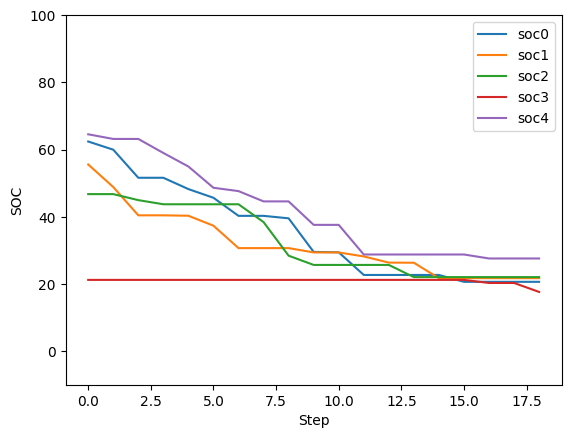

In [175]:
import time



def test_trained_model():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        oldObs = obs
        obs, rewards, done, info = model.get_env().step(action)
        episode_reward += rewards.squeeze()

        if not done:
            print(str(oldObs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([-10, 100])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            obsArray = []
            episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break


# def test_paralel_model():

#     env = BatteryEnv(5, False)
#     env = DummyVecEnv([lambda: env])

#     # intialized here
#     obs = env.reset()
    
#     episode_reward = 0
#     obsArray = []

#     while True:
#         action, _states = model.predict(obs)
#         oldObs = obs
#         obs, rewards, done, info = model.get_env().step(action)
#         episode_reward += rewards.squeeze()

#         print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")


#         if not done:
#             print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")
#             print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
#         else:
#             info_item = info.pop()
#             print("FINAL: ")
#             print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
#             print(str(str(action.flatten())))
#             print("REWARD:  " + str(rewards[0]))
#             print("EPISODE TOTAL REWARD: " + str(episode_reward))

#             # plot final model
#             fig = plt.figure(1)

#             data_np = np.array(obsArray)

#             plt.xlabel('Step')
#             plt.ylabel('SOC')
#             print("------------------------------------------------------")
#             plt.ylim([-10, 100])


#             i = 0
#             for soc in data_np.T:
#                 plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
#                 i += 1

#             plt.legend()
#             #plt.pause(3)

#             obsArray = []
#             episode_reward = 0
#             obs = model.get_env().reset()

#             break




test_trained_model()


In [22]:
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import A2C, SAC, PPO, TD3

# env = Monitor(gym.make("Pendulum-v1"))
# env = DummyVecEnv([lambda: env])

# model = A2C("MlpPolicy", env, verbose=1).learn(int(5000))